In [1]:
import pydra

In [4]:
@pydra.to_task
def add_two(x):
    return x + 2

@pydra.to_task
def power(a, n=2):
    return a**n

@pydra.to_task
def mult_var(a, b):
    return a * b

### Workflow

In order to run multiple tasks in on pipeline, we use `Workflow`. Let's start from a workflow with a single task.

Let's create a workflow that has one input `x` (we have to specify `input_spec` that contains all of the inputs):

In [11]:
wf1 = pydra.Workflow(name="wf1", input_spec=["x"], x=2)

Now, we can add a task and specify that `x` will be taken from the workflow input by using so called *Lazy Input*, `x=wf1.lzin.x`:

In [12]:
wf1.add(add_two(name="add_two", x=wf1.lzin.x))

wf1

Now, we have to specify what would be the workflow output, for the simplest workflow we don't have too much choice:

In [13]:
wf1.set_output([("out", wf1.add_two.lzout.out)])

Now, we are ready to run the workflow:

In [14]:
with pydra.Submitter(plugin="cf") as sub:
    sub(wf1)

wf1.result()

Result(output=Output(out=4), runtime=None, errored=False)

You can add as many task as you want to the workflow and return multiple variables

In [15]:
wf2 = pydra.Workflow(name="wf2", input_spec=["x"], x=2)
wf2.add(add_two(name="add_two", x=wf2.lzin.x))
wf2.add(power(name="power", a=wf2.lzin.x))

wf2.set_output([("add_two", wf2.add_two.lzout.out),
                ("power", wf2.power.lzout.out)
               ])

with pydra.Submitter(plugin="cf") as sub:
    sub(wf2)

wf2.result()

Result(output=Output(add_two=4, power=4), runtime=None, errored=False)

#### connecting nodes

Previous example showed a workflow with two nodes, but they were not connected with each other, they simply took input from the workflow and returned two outputs.

If we want to connect nodes, we simply have to set the input of the second node to the output of the first node.

In [16]:
wf3 = pydra.Workflow(name="wf3", input_spec=["x"], x=2)
wf3.add(add_two(name="add_two", x=wf3.lzin.x))
wf3.add(power(name="power", a=wf3.add_two.lzout.out))

wf3.set_output([("add_two", wf3.add_two.lzout.out),
                ("power", wf3.power.lzout.out)
               ])

with pydra.Submitter(plugin="cf") as sub:
    sub(wf3)

wf3.result()

Result(output=Output(add_two=4, power=16), runtime=None, errored=False)

Now, we could see that the second node took an input from the first node, we can check it:

In [17]:
wf3.power.inputs.a

4

The node can be connected to multiple nodes, we can modify `wf` to add additional node that uses `mult_var` to multiple the outputs of two previous nodes

In [18]:
wf4 = pydra.Workflow(name="wf2", input_spec=["x"], x=2)
wf4.add(add_two(name="add_two", x=wf4.lzin.x))
wf4.add(power(name="power", a=wf4.lzin.x))
wf4.add(mult_var(name="mult", a=wf4.add_two.lzout.out, b=wf4.power.lzout.out))

wf4.set_output([("wf_out", wf4.mult.lzout.out)])

with pydra.Submitter(plugin="cf") as sub:
    sub(wf4)

wf4.result()

Result(output=Output(wf_out=16), runtime=None, errored=False)

#### workflow with splitter

Workflow as any task could also have a splitter. Let's take the previous workflow and add a splitter for the workflow input by setting `splitter` using `split` method.

In [19]:
wf5 = pydra.Workflow(name="wf2", input_spec=["x"])
wf5.split(splitter="x", x=[2, 3, 5])
wf5.add(add_two(name="add_two", x=wf5.lzin.x))
wf5.add(power(name="power", a=wf5.lzin.x))
wf5.add(mult_var(name="mult", a=wf5.add_two.lzout.out, b=wf5.power.lzout.out))

wf5.set_output([("wf_out", wf5.mult.lzout.out)])

with pydra.Submitter(plugin="cf") as sub:
    sub(wf5)

wf5.result()

[Result(output=Output(wf_out=16), runtime=None, errored=False),
 Result(output=Output(wf_out=45), runtime=None, errored=False),
 Result(output=Output(wf_out=175), runtime=None, errored=False)]

As we could expect, we received a list with three `Result`s. 

Let's create a new workflow that has two inputs and more complicated splitter.

In [20]:
wf6 = pydra.Workflow(name="wf2", input_spec=["x", "y"])
wf6.split(splitter=["x", "y"], x=[2, 3, 5], y=[1, 2])
wf6.add(add_two(name="add_two", x=wf6.lzin.x))
wf6.add(power(name="power", a=wf6.lzin.y))
wf6.add(mult_var(name="mult", a=wf6.add_two.lzout.out, b=wf6.power.lzout.out))

wf6.set_output([("wf_out", wf6.mult.lzout.out)])

with pydra.Submitter(plugin="cf") as sub:
    sub(wf6)

wf6.result()

[Result(output=Output(wf_out=4), runtime=None, errored=False),
 Result(output=Output(wf_out=16), runtime=None, errored=False),
 Result(output=Output(wf_out=5), runtime=None, errored=False),
 Result(output=Output(wf_out=20), runtime=None, errored=False),
 Result(output=Output(wf_out=7), runtime=None, errored=False),
 Result(output=Output(wf_out=28), runtime=None, errored=False)]

#### adding combiner

Now we have six `Result`s! But we can also combine all or some results using the `combiner`. Let's combine results for all `x`.

In [21]:
wf6.combine(combiner="x")

with pydra.Submitter(plugin="cf") as sub:
    sub(wf6)

wf6.result()

[[Result(output=Output(wf_out=4), runtime=None, errored=False),
  Result(output=Output(wf_out=5), runtime=None, errored=False),
  Result(output=Output(wf_out=7), runtime=None, errored=False)],
 [Result(output=Output(wf_out=16), runtime=None, errored=False),
  Result(output=Output(wf_out=20), runtime=None, errored=False),
  Result(output=Output(wf_out=28), runtime=None, errored=False)]]

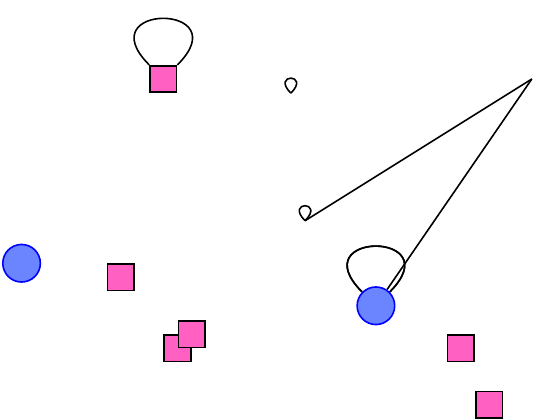